In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoModelForImageTextToText, pipeline
from huggingface_hub import login
from rouge import Rouge
import re
import pandas as pd
import numpy as np
from typing import TypedDict
from IPython.display import Image
import os
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
import torch
from peft import PeftModel
from tqdm.auto import tqdm
from dotenv import load_dotenv
from transformers import logging
logging.set_verbosity_error()

# 1. Original T5

In [2]:
combined_text = pd.read_csv("data/combined_text.csv")

In [3]:
summarizer =  pipeline("summarization", model="t5-small",tokenizer="t5-small")

Device set to use cuda:0


In [4]:
def summarize_text(text, min_chars=500, max_len=150, min_len=40):
    if len(text.strip()) < min_chars:
        return ""
    try:
        prompt = "summarize: " + text.strip()
        summary = summarizer(prompt, max_length=max_len, min_length=min_len, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [5]:
def summarize_long(text):
    return summarize_text(text, max_len=400, min_len=150)

def summarize_short(text):
    return summarize_text(text,max_len=150, min_len=100)

def summarize_tiny(text):
    return summarize_text(text, max_len=40, min_len=15)

In [8]:
combined_text['summary_long'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_long)
combined_text['summary_short'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_short)
combined_text['summary_tiny'] = combined_text['combined_cleaned_whisper_text'].apply(summarize_tiny)

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 400, but your input_length is only 398. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=199)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 400, but your input_length is only 342. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=171)
Your max_length is set to 400, but your input_length is only 198. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manua

In [ ]:
combined_text.to_csv("data/original_t5_summary.csv", index = False)

# 2. T5 Fine-Tuning

In [59]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

adapter_sizes = ["tiny", "short", "long"]
summarizers = {}

for size in adapter_sizes:
    adapter_path = os.path.join("LoRA_Weights", f"lora_adapters_{size}")
    
    # load fresh model for each size
    base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
    model_with_lora = PeftModel.from_pretrained(base_model, adapter_path)

    summarizer = pipeline(
        "summarization",
        model=model_with_lora,
        tokenizer=tokenizer
    )

    summarizers[size] = summarizer

Device set to use mps:0
The model 'PeftModelForSeq2SeqLM' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'

In [77]:
# Control length of summaries per style
length_map = {
    "tiny": (10, 40),
    "short": (100, 150),
    "long": (150, 400)
}

def clean_summary(text, add_paragraphs=False):
    if not text:
        return ""
    
    # ensure proper ending punctuation
    if not text.endswith(('.', '!', '?')):
        # find the last sentence ending or comma
        # since a lot of the tiny paragraphs ends at comma, so we cleaned it up more here
        last_period = max(text.rfind('.'), text.rfind('!'), text.rfind('?'))
        last_comma = text.rfind(',')
        
        if last_period > 0 and last_period > last_comma:
            # if it is a proper sentence, then just go with it
            text = text[:last_period+1]
        elif last_comma > 0:
            # if we have comma but no proper sentence ending, replace the comma with period
            # seen lots of case are like this for tiny
            text = text[:last_comma] + "."
        else:
            # if no ending found, add period
            text = text.rstrip() + "."
    
    # add pargraph breaks for long summary
    # since the data used for fine-tuning model is mostly 3 sentences for each paragraph, so we break the paragraph for every 3 sentences.
    if add_paragraphs:
        abbreviations = [r"Mr\.", r"Mrs\.", r"Ms\.", r"Dr\."]
        # protect abbreviations by replacing their “.” with a placeholder
        # clean out the dot on the abbreviation
        protected = text
        for abbr in abbreviations:
            protected = re.sub(abbr, lambda m: m.group(0).replace(".", "<DOT>"),protected)

        # split based on the sentence punctuation
        parts = re.split(r'(?<=[.!?])\s+', protected)

        # restore the '.' in the abbreviation
        sentences = [p.replace("<DOT>", ".") for p in parts]
        
        # only add paragraphs if we have enough sentences
        if len(sentences) >= 4:  # need at least 4 sentences to have more than one paragraph
            paragraphs = []
            current_para = []
            
            for i, sentence in enumerate(sentences):
                current_para.append(sentence)
                
                # create a paragraph break after every 3rd sentence
                if (i + 1) % 3 == 0 and i < len(sentences) - 1:
                    paragraphs.append(' '.join(current_para))
                    current_para = []
            
            # add any remaining sentences as the final paragraph
            if current_para:
                paragraphs.append(' '.join(current_para))
            
            text = '\n\n'.join(paragraphs)
    
    return text

In [78]:
def summarize_finetuned(text, length_type="short"):
    if length_type not in length_map:
        raise ValueError(f"Length type '{length_type}' not supported. Use: {list(length_map.keys())}")

    min_len, max_len = length_map[length_type]

    try:
        # use the correct summarizer based on length_type
        summarizer = summarizers[length_type]
        
        prompt = ("summarize: " + text.strip())[:1024]
        result = summarizer(prompt, min_length = min_len, max_length=max_len, do_sample=False)
        summary = result[0]["summary_text"]
        
        # apply cleaning and formatting based on length type
        add_paragraphs = length_type == "long"  # Only add paragraphs for long summaries
        summary = clean_summary(summary, add_paragraphs)
        
        return summary.strip()
    except Exception as e:
        print(f"Error: {e}")
        return ""

In [83]:
text = combined_text['combined_cleaned_whisper_text'].loc[0]

print(f"Tiny Summary:\n{summarize_finetuned(text, 'tiny')}")
print(f"Short Summary:\n{summarize_finetuned(text, 'short')}")
print(f"Long Summary:\n{summarize_finetuned(text, 'long')}")

Tiny Summary:
Mr. Quilter is the apostle of the middle classes, and he tells us that at this festive season, with Christmas and roast beef looming before us similarly drawn from eating.
Short Summary:
Mr. Quilter is the apostle of the middle classes and we welcome his gospel. He has doubts whether Sir Fred Layton's work is really greek after all and can discover in it, but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings, and masons exquisite ittles are as national as a jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. Clark gives his sitter a cheerful slap on the back.
Long Summary:
Mr. Quilter, an advocate for the middle class, is the apostle of the middle classes and is glad to welcome his gospel. He tells us that at this festive season of the year, roast beef looms before us, drawing from eating and its results most readily to the mind. He has doubts whether Sir Frederick Layt

In [84]:
text = combined_text['combined_cleaned_whisper_text'].loc[1]

print(f"Tiny Summary:\n{summarize_finetuned(text, 'tiny')}")
print(f"Short Summary:\n{summarize_finetuned(text, 'short')}")
print(f"Long Summary:\n{summarize_finetuned(text, 'long')}")

Tiny Summary:
The king is flooded with disgrace, and his friends ask for him to send him away, but he doesn't work too hard, especially since shaggy.
Short Summary:
Poroshaegi sits in the room beside the dragon and witnessed the occurrences with interest. The little girl had been asleep, but she heard the raps and opened the door. The king is flooded with disgrace and friends are asking for him to send him away, but he would not go, and eats and sleeps steadily, despite shaggy's lack of work in these dominions and our norms, which worries us to keep them busy.
Long Summary:
Polychrome, an advocate for the middle class, argues that the lovely rose princess has become a fiddle without a bow, and Poroshaegi sits there, accuing Dove, who has gone and gone for good, answered Polychrom, who had managed to squeeze into the room beside the dragon. The little girl had been asleep, but she heard the raps and opened the door, and the king is flooded disgrace, and her friends are asking for you. T

In [88]:
# use tqdm to see the progress bar of the summarization
tqdm.pandas()

# create a new variable for the summarization
text_with_summary = combined_text.copy()

# do for loop for every style
for style in ["tiny", "short", "long"]:
    text_with_summary[f"summary_{style}"] = (text_with_summary["combined_cleaned_whisper_text"]
                                             .progress_apply(lambda txt: summarize_finetuned(txt, length_type=style)))

  0%|          | 0/97 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 97/97 [13:57<00:00,  8.64s/it]


In [89]:
text_with_summary.head()

,folder_path,combined_cleaned_whisper_text,named_entities,summary_tiny,summary_short,summary_long
0,1272/128104,mr quilter is the apostle of the middle classes and we are glad to welcome his gospel nor is mr quilters manner less interesting than his matter he tells us that at this festive season of the year with christmas and roast beef looming before us similarly drawn from eating and its results occur most readily to the mind he has graved doubts whether sir frederick laytons work is really greek after all and can discover in it but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings and masons exquisite ittles are as national as a jingo poem mr birkett fosters landscapes smile at one much in the same way that mr carker used to flash his teeth and mr john collier gives his sitter a cheerful slap on the back before he says like a shampoo or a turkish bath next man it is obviously unnecessary for us to point out how luminous these criticisms are how delicate in expression on the general principles of art and mr krilter writes with equal lucidity painting he tells us is of a different quality to mathematics and finish in art is adding more factor as for etchings there are two kinds british and foreign he laments most bitterly the divorce that has been made between decorative art and what we usually call pictures mixed a customary appeal to the last judgment and reminds us that in the great days of art michelangelo was the furnishing upholsterer near the fire and the ornaments fred brought home from india on the mental board in fact he is quite severe on mr ruskin for not recognizing that a picture should denote the frailty of man and remarks with pleasing courtesy and felicitous grace that many phases were feeling only unfortunately his own work never does get good mr quilter has missed his chance for he has failed even to make himself the tupper of painting by harry quilter ma,"[(quilter, PERSON), (quilters, PERSON), (this festive season of the year, DATE), (christmas, DATE), (frederick laytons, PERSON), (greek, NORP), (upgards, PERSON), (atom, PERSON), (masons, PERSON), (birkett, PERSON), (carker, PERSON), (john collier, PERSON), (turkish, NORP), (krilter, PERSON), (two, CARDINAL), (british, NORP), (the great days, DATE), (michelangelo, PERSON), (fred, PERSON), (india, GPE), (the mental board, ORG), (ruskin, PERSON), (quilter, PERSON), (harry quilter ma, PERSON)]","Mr. Quilter is the apostle of the middle classes, and he tells us that at this festive season, with Christmas and roast beef looming before us similarly drawn from eating.","Mr. Quilter is the apostle of the middle classes and we welcome his gospel. He has doubts whether Sir Fred Layton's work is really greek after all and can discover in it, but little of rocky ithaca lynelles pictures are a sort of upgards and atom paintings, and masons exquisite ittles are as national as a jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. Clark gives his sitter a cheerful slap on the back.","Mr. Quilter, an advocate for the middle class, is the apostle of the middle classes and is glad to welcome his gospel. He tells us that at this festive season of the year, roast beef looms before us, drawing from eating and its results most readily to the mind. He has doubts whether Sir Frederick Layton's work is really greek after all, and can discover little of rocky Ithaca.\n\nLynelles pictures are a sort of upgards and atom paintings, and Masons, exquisite ittles are as national as a Jingo poem. Mr. Birkett fosters landscapes smile at one much in the same way as Mr. Carker used to flash his teeth, and Mr. John Collier gives his sitter a cheerful slap on the back before saying like a shampoo or turkish bath. He asks that he asks us about how luminous these criticisms are on the general principles of art and Mr. Krilter writes with equal lucidity painting as he says it is unnecessary for

In [ ]:
text_with_summary.to_csv("data/fine_tune_t5_summary.csv", index = False)

# 3. LLM-Based Agentic Summarizer with In-Context Learning

In [3]:
# get hugging face token and log in
load_dotenv()
hf_token = os.getenv("HUGGINGFACE_TOKEN")
login(hf_token)

In [4]:
# read combined text csv
combined_text = pd.read_csv("data/combined_text.csv")

In [10]:
# load llama 3
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             torch_dtype=torch.float16, 
                                             device_map="auto")

Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


In [36]:
def llm(prompt, max_new_tokens=512, temperature=0.4):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if prompt in decoded:
        return decoded[len(prompt):].strip()
    return decoded.strip()

In [37]:
# summarizer prompt
def get_long_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization. 
<|user|>
I need you to summarize the following text into three to five paragraphs (150–400 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
A merchant with three daughters traveled each year to a distant city to collect money. One evening during a terrible storm, while the merchant was away, a beggar came to their house asking for shelter. The eldest daughters, moved by his plea, insisted on letting him in despite their youngest sister’s warning that they should honor their father’s instructions.

During dinner, the beggar secretly sprinkled sleeping powder on the apples meant for dessert. The two elder sisters ate the apples and fell asleep, but the youngest, suspicious, did not eat hers. Awake and alert, she heard the beggar—revealed to be a robber—go downstairs to unbolt the doors leading to the merchant’s store. Realizing her plan was foiled, the robber chief became furious, and his gang tried in vain to break into the house.

Despite their efforts and curses, the youngest daughter’s caution and bravery protected the household from harm. Her wisdom proved greater than her sisters’ kindness, showing that mercy should be tempered with vigilance, especially when danger is near.

<|user|>
Now please summarize this text into two to four paragraphs:

{text}

<|assistant|>
"""

def get_short_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
I need you to summarize the following text into a single concise paragraph (100–150 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
While their merchant father was away, three sisters sheltered a beggar during a fierce storm, despite the youngest’s warning to keep their promise to their father. The beggar, actually a robber in disguise, drugged the elder sisters with sleeping powder, but the cautious youngest sister avoided the trap. Staying awake, she overheard the robber’s plan to break into the house and foiled his attempt, saving her family through her vigilance and quick thinking.

<|user|>
Now please summarize this text into a single concise paragraph:

{text}

<|assistant|>
"""

def get_tiny_summary_prompt(text):
    return f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
I need you to summarize the following text into a single sentence (15–40 words). Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Example text: long ago they lived in merchant who had three daughters every year at a certain day of a certain month he went away to a distant city to collect money when an account how do you know astor father i am older and wiser than you are and i know that there are many evils which might come upon you when it was evening he led his band into a nearby street and in his disguise approached the merchants house he knocked at the door have pity upon a poor unfortunate one he called out let me enter i pray you to pass the night under your roof its surely a terrible storm outside so the merchants eldest daughter as the wind rattled the tiles of the roof and the rain beat in torrents against the doors and windows he is old as well as poor she said if we decide to show mercy to this poor beggar it is not for you to oppose it but we should not forget our promise to our father cried the youngest daughter however in spite of all she could say the elder sisters opened the door and admitted the bigger it is a fearful night to send away a bigger said the eldest sister while they were eating while they were talking the beggar had taken the apples which the girls were to eat for dessert and had sprinkled a sleeping powder over them the two eldest ate their apples but the youngest could not eat that night she threw the apple away she did not stir and he knew that the sleeping powder had thoroughly done its work then she hurt him go down the stairway and unbolt the heavy doors which led into the store it was the youngest one who deceived me cried the robert chieftain perhaps we can outlet her yet cry another the merchants daughter at first did not answer but as he kept on calling to her she finally asked him what it was that he wanted i promise you i will do you no harm you shall not come into my fathers house pass the charm out to me then said the robber when she returned his hand was sticking through the hole in the door the cries and curses of the robbers filled the air they tried and vane to break down the great doors all my worries about you were foolish

<|assistant|>
When a beggar-turned-robber tricks two sisters into eating sleeping powder, the youngest sister’s caution thwarts his plan and protects her family.

<|user|>
Now please summarize this text into a single sentence:

{text}

<|assistant|>
"""

In [38]:
# evaluator prompt
def build_evaluator_prompt(original_text, summary, summary_type):
    return f"""<|system|>
You are a critical reviewer of summaries. You read an original text, a summary, and decide if the summary is good or not, following the provided examples. Output your decision and feedback using the format shown in the examples.

<|user|>
Example 1:
Original text:
The cat sat on the mat. The dog barked at the mailman.

Summary:
A cat sat on a mat while a dog barked at a mailman.

Evaluation:
- Result: Pass
- Feedback: The summary covers all key details accurately and concisely.

Example 2:
Original text:
Alice goes to Wonderland and meets many strange creatures.

Summary:
Alice meets some people.

Evaluation:
- Result: Fail
- Feedback: The summary is too vague and omits many important plot points.

Now, evaluate the following summary:

Original text:
{original_text}

Summary:
{summary}

Return your response in this format:
- Result: <Pass or Fail>
- Feedback: <Your feedback>
<|assistant|>
"""

In [39]:
# regenerator prompt
def get_regenerator_prompt(text, last_summary, feedback, summary_type):
    if summary_type == "long":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text into three to five paragraphs (150–400 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    elif summary_type == "short":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text in a single paragraph (100–150 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    elif summary_type == "tiny":
        prompt = f"""<|system|>
You are a helpful AI assistant specialized in text summarization.
<|user|>
Please summarize the original text in a single sentence (15–40 words), addressing the evaluator's feedback of the last summary below. Return only the summary. Do not include any introductory or concluding sentences, explanations, or conversational statements. Your output must be the summary only.

Original text:
{text}

Last summary:
{last_summary}

Evaluator feedback of last summary:
{feedback}
<|assistant|>
"""
    else:
        raise ValueError("Invalid summary_type.")
    return prompt

In [40]:
# define agents
def summarizer_node(state):
    summary_type = state["summary_type"]
    text = state["text"]
    if summary_type == "long":
        prompt = get_long_summary_prompt(text)
    elif summary_type == "short":
        prompt = get_short_summary_prompt(text)
    elif summary_type == "tiny":
        prompt = get_tiny_summary_prompt(text)
    else:
        raise ValueError("Invalid summary_type.")
    state["summary"] = llm(prompt)
    return state

def evaluator_node(state):
    eval_prompt = build_evaluator_prompt(state["text"], state["summary"], state["summary_type"])
    eval_result = llm(eval_prompt)
    state["eval_result"] = eval_result
    state["pass"] = "pass" in eval_result.lower()
    return state

def regenerator_node(state):
    state["attempts"] = state.get("attempts", 0) + 1
    feedback = state["eval_result"]
    summary_type = state["summary_type"]
    text = state["text"]
    last_summary = state["summary"]

    prompt = get_regenerator_prompt(text, last_summary, feedback, summary_type)
    state["summary"] = llm(prompt)
    return state

def router(state):
    if state.get("pass", False) or state["attempts"] >= 3:
        return END
    else:
        print('Finished trial ' + str(state["attempts"]+1))
        return "regenerator"

In [41]:
# create graph
class SummaryState(TypedDict, total=False):
    text: str
    summary_type: str
    summary: str
    eval_result: str
    pass_: bool
    attempts: int

graph = StateGraph(state_schema=SummaryState)
graph.add_node("summarizer", summarizer_node)
graph.add_node("evaluator", evaluator_node)
graph.add_node("regenerator", regenerator_node)
graph.add_edge("summarizer", "evaluator")
graph.add_conditional_edges("evaluator", router)
graph.add_edge("regenerator", "evaluator")
graph.set_entry_point("summarizer")
langgraph_pipeline = graph.compile()

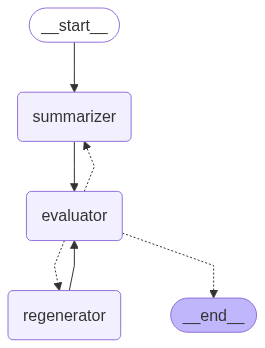

In [42]:
# visualize graph
display(
    Image(
        langgraph_pipeline.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [43]:
# clean generated text
def clean_summary(text):
    lines = text.strip().split('\n')
    cleaned_lines = []
    stop_markers = re.compile(r'^\s*(<\|system\|>|<\|user\|>|<\|assistant\|>|system|user|assistant|Generated text)', re.IGNORECASE)
    skip_markers = re.compile(r'^\s*(here|improved|revised|rewritten|summary)[^:]*:', re.IGNORECASE)

    for line in lines:
        if stop_markers.match(line):
            break  # stop collecting lines
        if skip_markers.match(line):
            continue  # skip this line
        stripped = line.strip()
        if stripped:
            cleaned_lines.append(stripped)
    return '\n\n'.join(cleaned_lines)

In [44]:
def get_summary(text, summary_type):
    state = {
        "text": text,
        "summary_type": summary_type,
        "attempts": 0
    }
    result = langgraph_pipeline.invoke(state)
    if not result.get("pass", False) and result["attempts"] >= 3:
        return "Can't generate summary. Please try again."
    else:
        #print(result['eval_result'])
        return clean_summary(result["summary"])

In [27]:
# test one example
print(get_summary(combined_text['combined_cleaned_whisper_text'].loc[20], "tiny"))

Peter, struggling with financial woes and personal troubles, seeks advice from Mr. Shimera, while elsewhere, Pavel and his companions flee their village, pursued by a dark past and haunted by the sound of a distant monastery bell.


In [ ]:
combined_text["summary_long"] = ""
combined_text["summary_short"] = ""
combined_text["summary_tiny"] = ""

for idx, row in tqdm(combined_text.iterrows(), total=len(combined_text)):
    text = row["combined_cleaned_whisper_text"]
    combined_text.at[idx, "summary_long"]  = get_summary(text, "long")
    combined_text.at[idx, "summary_short"] = get_summary(text, "short")
    combined_text.at[idx, "summary_tiny"]  = get_summary(text, "tiny")

  3%|▎         | 3/97 [02:01<1:02:57, 40.18s/it]

Finished trial 1
Finished trial 2


  4%|▍         | 4/97 [03:23<1:27:51, 56.68s/it]

Finished trial 1


  6%|▌         | 6/97 [05:02<1:17:55, 51.38s/it]

Finished trial 1


  7%|▋         | 7/97 [06:27<1:33:40, 62.45s/it]

Finished trial 1
Finished trial 1


  8%|▊         | 8/97 [07:56<1:45:20, 71.02s/it]

Finished trial 1


 11%|█▏        | 11/97 [10:29<1:19:29, 55.46s/it]

Finished trial 1
Finished trial 1
Finished trial 2


 15%|█▌        | 15/97 [14:19<1:10:39, 51.70s/it]

Finished trial 1


 21%|██        | 20/97 [17:43<52:01, 40.54s/it]  

Finished trial 1
Finished trial 2
Finished trial 3


 22%|██▏       | 21/97 [19:35<1:18:22, 61.87s/it]

Finished trial 1
Finished trial 1


 33%|███▎      | 32/97 [29:23<57:34, 53.15s/it]  

Finished trial 1
Finished trial 1


 46%|████▋     | 45/97 [41:00<49:49, 57.49s/it]  

Finished trial 1
Finished trial 1


 51%|█████     | 49/97 [45:10<44:45, 55.95s/it]

Finished trial 1
Finished trial 2
Finished trial 3


 61%|██████    | 59/97 [54:12<32:32, 51.38s/it]

Finished trial 1


 64%|██████▍   | 62/97 [56:57<30:43, 52.68s/it]

Finished trial 1
Finished trial 2
Finished trial 1


 73%|███████▎  | 71/97 [1:05:12<20:55, 48.28s/it]

Finished trial 1


 75%|███████▌  | 73/97 [1:06:55<19:27, 48.66s/it]

In [50]:
# check rows without successful generation in 3 trials
summary_cols = ['summary_long', 'summary_short', 'summary_tiny']
invalid_msg = "Can't generate summary. Please try again."

llama3_fail = combined_text[(combined_text[summary_cols] == invalid_msg).any(axis=1)]
llama3_fail

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny
49,3853/163249,her meeting with ledi was indescribably tender...,"[('ledi', 'PERSON'), ('christi', 'PERSON'), ('...",Can't generate summary. Please try again.,"Christie and David, now a married couple, prep...",As Christie and David prepare for their weddin...
92,84/121550,but with full ravishment the hours of prime si...,"[('prosupina', 'PERSON'), ('venus', 'PERSON'),...",Can't generate summary. Please try again.,"As I walked with the lady, our path turned eas...",As Dante and Virgil journey through the afterl...


In [51]:
# manully regenerate summary for these rows
for idx, row in llama3_fail.iterrows():
    text = row['combined_cleaned_whisper_text']
    combined_text.at[idx, "summary_long"]  = get_summary(text, "long")
    combined_text.at[idx, "summary_short"] = get_summary(text, "short")
    combined_text.at[idx, "summary_tiny"]  = get_summary(text, "tiny")


Finished trial 1
Finished trial 2


In [52]:
# check rows without successful generation in 3 trials again
llama3_fail = combined_text[(combined_text[summary_cols] == invalid_msg).any(axis=1)]
llama3_fail

,folder_path,combined_cleaned_whisper_text,named_entities,summary_long,summary_short,summary_tiny


In [ ]:
combined_text.to_csv("data/llama_agent_summary.csv", index = False)